In [1]:
from analysis.loaders import load_rave_and_nonrave
from analysis.metrics import (
    compute_nmv, compute_nvd, compute_av,
    compute_vdv, compute_vdv_ratios
)
from analysis.categories import categorize
from analysis.plotting import (
    plot_comfort_thresholds,
    plot_vdv_over_time,
    plot_ratio_comparison,
    plot_compare_all_metrics,
    plot_comfort_timeseries,
    plot_iso_timeseries
)

import numpy as np
import pandas as pd

In [ ]:
# Category definitions
categories = [
    ((0, 1.5), 'Very Comfortable'),
    ((1.5, 2.5), 'Comfortable'),
    ((2.5, 3.5), 'Medium'),
    ((3.5, 4.5), 'Uncomfortable'),
    ((4.5, 6.0), 'Very Uncomfortable')
]

# Pair floor & seat triaxials (floor,seat)
pairs = [
    ((1,6), 'Motor Truck'),
    ((3,2), 'Between Trucks'),
    ((5,4), 'Center Truck')
]


# Load data
(x_rave, y_rave, z_rave), (x_raw, y_raw, z_raw) = load_rave_and_nonrave("data/")


RAVE files: ['N2n0000005-RAVE-001.CSV', 'N2n0000005-RAVE-002.CSV', 'N2n0000005-RAVE-003.CSV']
Raw files: ['N2n0000005-001.CSV', 'N2n0000005-002.CSV', 'N2n0000005-003.CSV']


In [3]:
# Every 5th running average
x5 = x_rave.iloc[4::5]
y5 = y_rave.iloc[4::5]
z5 = z_rave.iloc[4::5]

Cx = x5['ISO-WD']
Cy = y5['ISO-WD']
Cz = z5['EN-WB']


# Percentile inputs
Ax95 = np.percentile(Cx, 95)
Ay95 = np.percentile(Cy, 95)
Az95 = np.percentile(Cz, 95)
Ax50 = np.percentile(Cx, 50)
Ay50 = np.percentile(Cy, 50)
Az50 = np.percentile(Cz, 50)

# Calculate comfort indices
N_MV = compute_nmv(Ax95, Ay95, Az95)
N_VD = compute_nvd(Ax50, Ay50, Az50, Ay95)

print(f"N_M_V = {N_MV:.2f} → {categorize(N_MV, categories)}")
print(f"N_V_D = {N_VD:.2f} → {categorize(N_VD, categories)}")

N_M_V = 0.01 → Very Comfortable
N_V_D = 0.01 → Very Comfortable


In [4]:
Cx, Cy, Cz # not much data to work with for percentile calculations, or time series plots

(4     0.000270
 9     0.000335
 14    0.000403
 19    0.000398
 24    0.000378
 29    0.000284
 Name: ISO-WD, dtype: float64,
 4     0.000107
 9     0.000362
 14    0.000223
 19    0.000270
 24    0.000342
 29    0.000879
 Name: ISO-WD, dtype: float64,
 4     0.000724
 9     0.001030
 14    0.000843
 19    0.000917
 24    0.000847
 29    0.000906
 Name: EN-WB, dtype: float64)

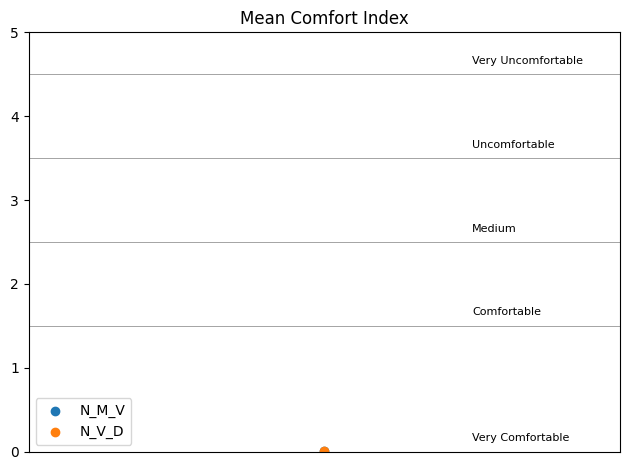

In [5]:
# Mean Comfort Index plot
plot_comfort_thresholds(N_MV, N_VD, categories)

In [6]:
# Full time vector 
t_all = pd.to_timedelta(x_raw['Number'], unit='s')
# Downsampled time vector to match 5s interval RAVE slices
t_5s = t_all[4::5]
t_5s_minutes = t_5s.dt.total_seconds() / 60

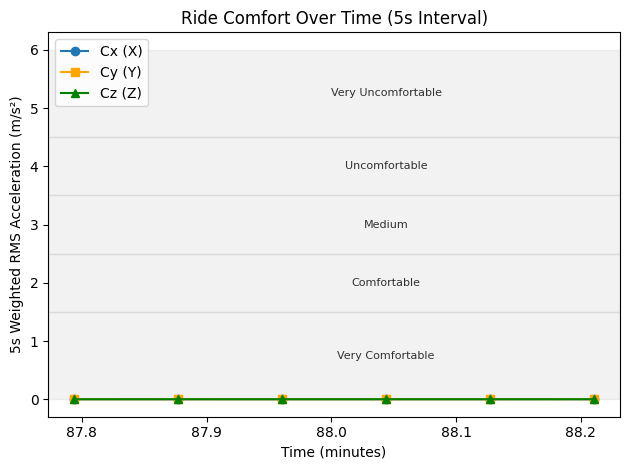

In [7]:
# 5s signals plot
plot_comfort_timeseries(t_5s_minutes, Cx, Cy, Cz)

In [8]:
#### For av calculation, note that I'm not implementing the kb control flow ###

# Compute AV
X_ISO = x_raw['ISO-WD']
Y_ISO = y_raw['ISO-WD']
Z_ISO = z_raw['ISO-WB']

a_v = compute_av(X_ISO, Y_ISO, Z_ISO)

# Compute a_v 
a_v_5s = compute_av(x5['ISO-WD'], y5['ISO-WD'], z5['ISO-WB'])

print(f"a_v (1s ISO composite) = {np.mean(a_v):.3f} m/s²")
print(f"a_v_5s (from RAVE)      = {np.mean(a_v_5s):.3f} m/s²")



a_v (1s ISO composite) = 0.001 m/s²
a_v_5s (from RAVE)      = 0.001 m/s²


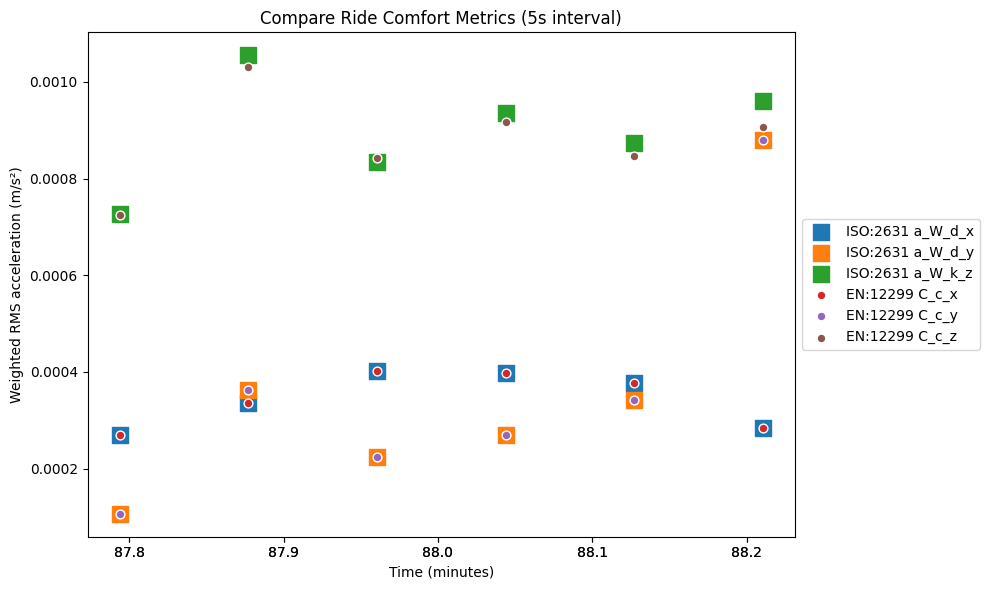

In [10]:
plot_compare_all_metrics(
    t_5s_minutes,
    x5['ISO-WD'],
    y5['ISO-WD'],
    z5['ISO-WK'],
    Cx, Cy, Cz
)

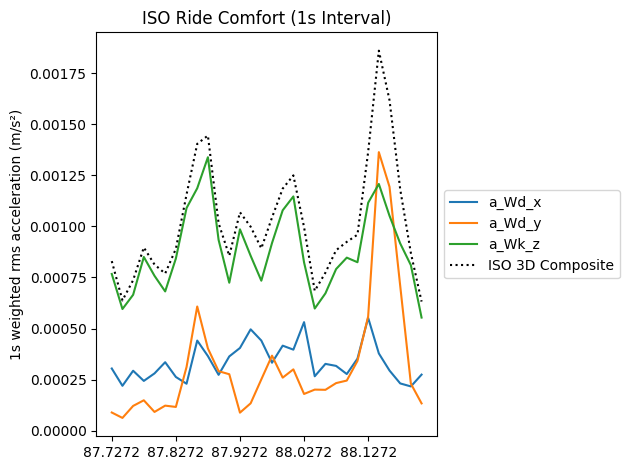

In [8]:
plot_iso_timeseries(t_all, X_ISO, Y_ISO, Z_ISO, a_v, a_v_5s, t_5s_minutes)

In [9]:
# VDV data
X_VDV = x_raw['WD4th_VDV']
Y_VDV = y_raw['WD4th_VDV']
Z_VDV = z_raw['WK4th_VDV']

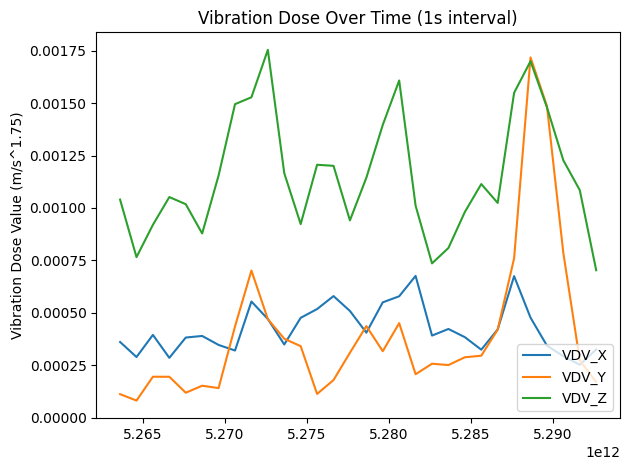

In [10]:
plot_vdv_over_time(t_all, X_VDV, Y_VDV, Z_VDV)

In [11]:
ratios = [
    compute_vdv_ratios(X_VDV, compute_vdv(X_ISO)),
    compute_vdv_ratios(Y_VDV, compute_vdv(Y_ISO)),
    compute_vdv_ratios(Z_VDV, compute_vdv(Z_ISO))
]

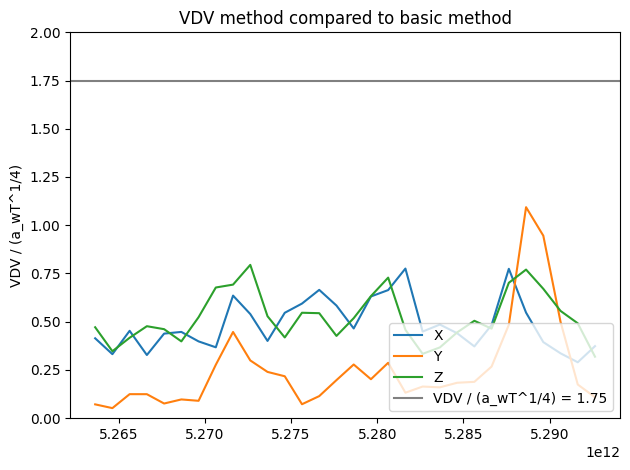

In [12]:
plot_ratio_comparison(t_all, ratios, labels=['X', 'Y', 'Z'])